In [8]:
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)
# Quanvolutional Neural Networks by Author: Andrea Mari 
# https://pennylane.ai/qml/demos/tutorial_quanvolution.html
# This cell is added by sphinx-gallery
%matplotlib inline

Time in seconds since beginning of run: 1682914005.660751
Sun Apr 30 21:06:45 2023


In [9]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# tensorrt not used

In [10]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 600    ## Size of the train dataset
n_test = 100     # Size of the test dataset

SAVE_PATH = "imageqnn/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [11]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [12]:
dev = qml.device("default.qubit", wires=8) ##
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j-2], wires=j) ##

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(8))) ##

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(8)] ##

In [13]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [14]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
600/600        
Quantum pre-processing of test images:


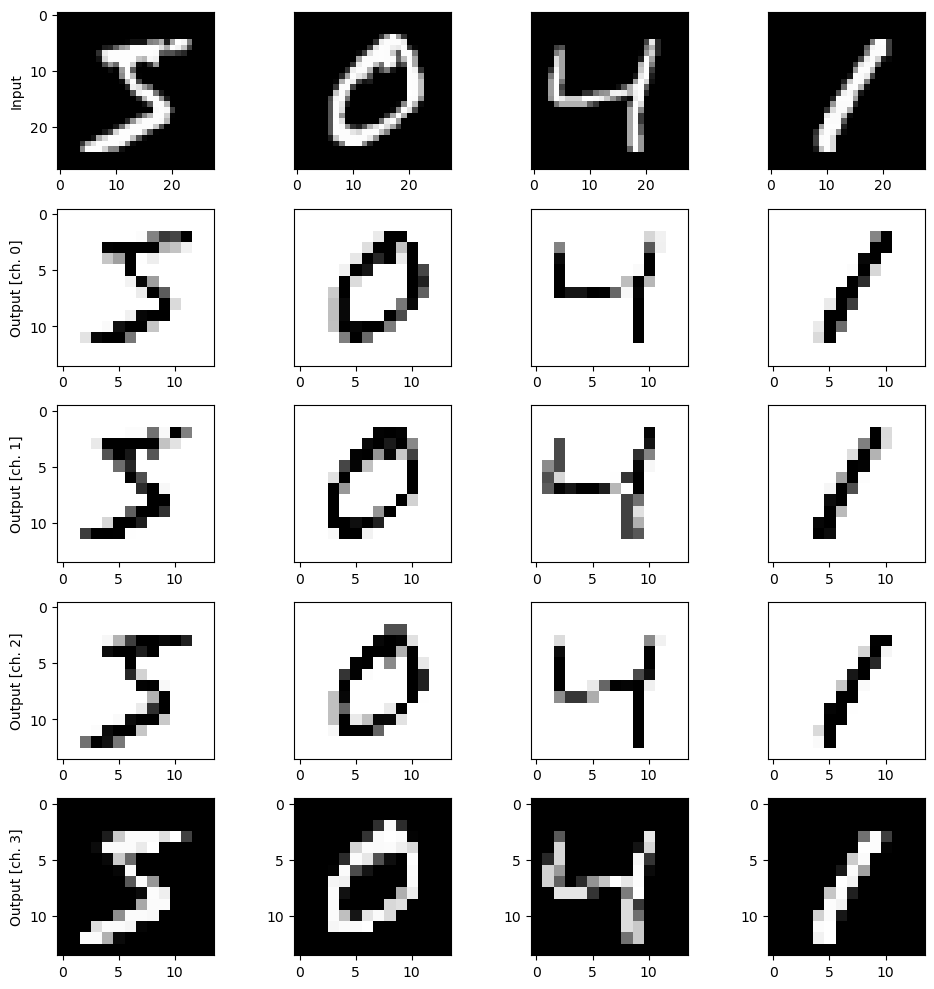

In [15]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [16]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [17]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
150/150 - 0s - loss: 1.4438 - accuracy: 0.5567 - val_loss: 0.9497 - val_accuracy: 0.7100 - 427ms/epoch - 3ms/step
Epoch 2/30
150/150 - 0s - loss: 0.6747 - accuracy: 0.8167 - val_loss: 0.8989 - val_accuracy: 0.7200 - 116ms/epoch - 771us/step
Epoch 3/30
150/150 - 0s - loss: 0.5239 - accuracy: 0.8417 - val_loss: 0.5978 - val_accuracy: 0.8500 - 101ms/epoch - 675us/step
Epoch 4/30
150/150 - 0s - loss: 0.4008 - accuracy: 0.8817 - val_loss: 0.6136 - val_accuracy: 0.7900 - 114ms/epoch - 761us/step
Epoch 5/30
150/150 - 0s - loss: 0.3414 - accuracy: 0.9067 - val_loss: 0.4831 - val_accuracy: 0.8500 - 105ms/epoch - 698us/step
Epoch 6/30
150/150 - 0s - loss: 0.2752 - accuracy: 0.9367 - val_loss: 0.4663 - val_accuracy: 0.8300 - 99ms/epoch - 657us/step
Epoch 7/30
150/150 - 0s - loss: 0.2411 - accuracy: 0.9333 - val_loss: 0.4625 - val_accuracy: 0.8400 - 100ms/epoch - 666us/step
Epoch 8/30
150/150 - 0s - loss: 0.1957 - accuracy: 0.9550 - val_loss: 0.4073 - val_accuracy: 0.8400 - 111ms/epoch 

In order to compare the results achievable with and without the quantum
convolution layer, we initialize also a \"classical\" instance of the
model that will be directly trained and validated with the raw MNIST
images (i.e., without quantum pre-processing).


In [18]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
150/150 - 0s - loss: 1.5891 - accuracy: 0.5850 - val_loss: 1.1266 - val_accuracy: 0.7000 - 340ms/epoch - 2ms/step
Epoch 2/30
150/150 - 0s - loss: 0.7952 - accuracy: 0.8450 - val_loss: 0.7911 - val_accuracy: 0.7900 - 128ms/epoch - 854us/step
Epoch 3/30
150/150 - 0s - loss: 0.5685 - accuracy: 0.8800 - val_loss: 0.6618 - val_accuracy: 0.8500 - 89ms/epoch - 593us/step
Epoch 4/30
150/150 - 0s - loss: 0.4502 - accuracy: 0.9117 - val_loss: 0.5869 - val_accuracy: 0.8500 - 147ms/epoch - 979us/step
Epoch 5/30
150/150 - 0s - loss: 0.3761 - accuracy: 0.9217 - val_loss: 0.5145 - val_accuracy: 0.8700 - 137ms/epoch - 912us/step
Epoch 6/30
150/150 - 0s - loss: 0.3265 - accuracy: 0.9300 - val_loss: 0.4860 - val_accuracy: 0.8700 - 140ms/epoch - 932us/step
Epoch 7/30
150/150 - 0s - loss: 0.2819 - accuracy: 0.9400 - val_loss: 0.4457 - val_accuracy: 0.8600 - 162ms/epoch - 1ms/step
Epoch 8/30
150/150 - 0s - loss: 0.2516 - accuracy: 0.9483 - val_loss: 0.4262 - val_accuracy: 0.8700 - 176ms/epoch - 

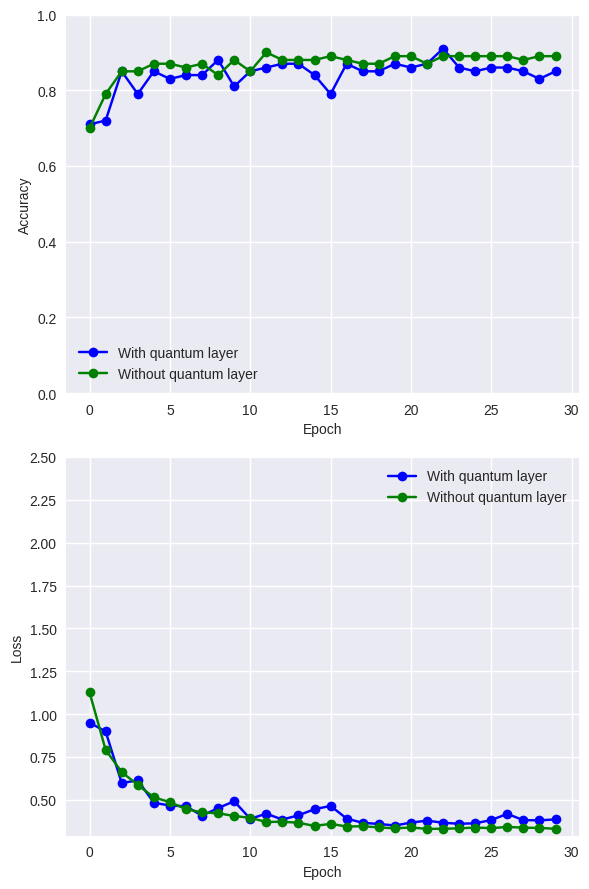

In [19]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
#plt.show()

References
==========

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.

About the author
================


In [20]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1682914540.0444183
Sun Apr 30 21:15:40 2023
